In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.12.0


Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


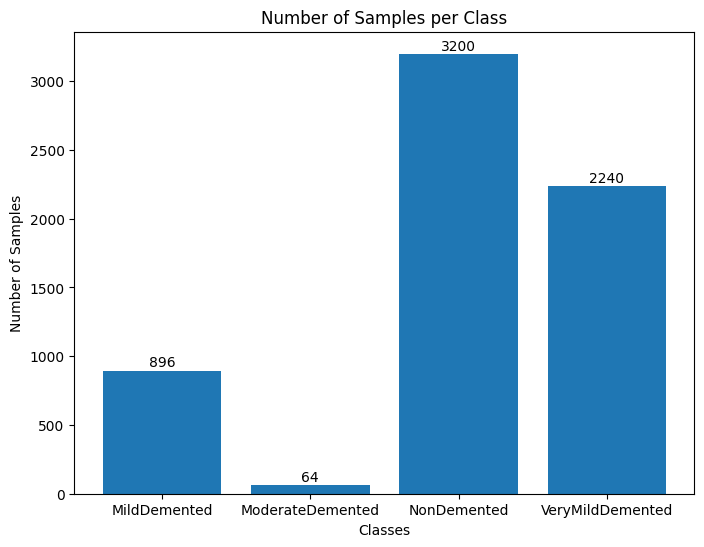

In [3]:
import os
import shutil
import matplotlib.pyplot as plt
from distutils.dir_util import copy_tree, remove_tree

# Set up the directories
base_dir = "Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)

# Check the contents of the working directory
print("Working Directory Contents:", os.listdir(work_dir))

# Count the number of samples in each class
classes = os.listdir(work_dir)
sample_count = []

for class_name in classes:
    class_path = os.path.join(work_dir, class_name)
    num_samples = len(os.listdir(class_path))
    sample_count.append(num_samples)

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(classes, sample_count)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class')

# Add sample count above each bar
for i, count in enumerate(sample_count):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()

In [4]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [5]:
import cv2
import os

def apply_binary_segmentation(image_path, output_path):
    # Load the input image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply color thresholding
    _, threshold = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

    # Apply binary mask to extract the segmented region
    segmented_image = cv2.bitwise_and(image, image, mask=threshold)

    # Save the segmented image
    cv2.imwrite(output_path, segmented_image)


# Paths
input_dir = "./dataset/"
output_dir = "./segmented_images/"

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate over the files in the directory and its subdirectories
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            image_path = os.path.join(root, file)
            
            # Create output subdirectory based on class label
            class_label = os.path.basename(root)
            class_output_dir = os.path.join(output_dir, class_label)
            if not os.path.exists(class_output_dir):
                os.makedirs(class_output_dir)
            
            output_path = os.path.join(class_output_dir, file)

            # Apply binary segmentation
            apply_binary_segmentation(image_path, output_path)

In [6]:
WORK_DIR="./segmented_images/"

In [7]:
#Performing Image Augmentation to have more data samples

ZOOM = 0.4
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


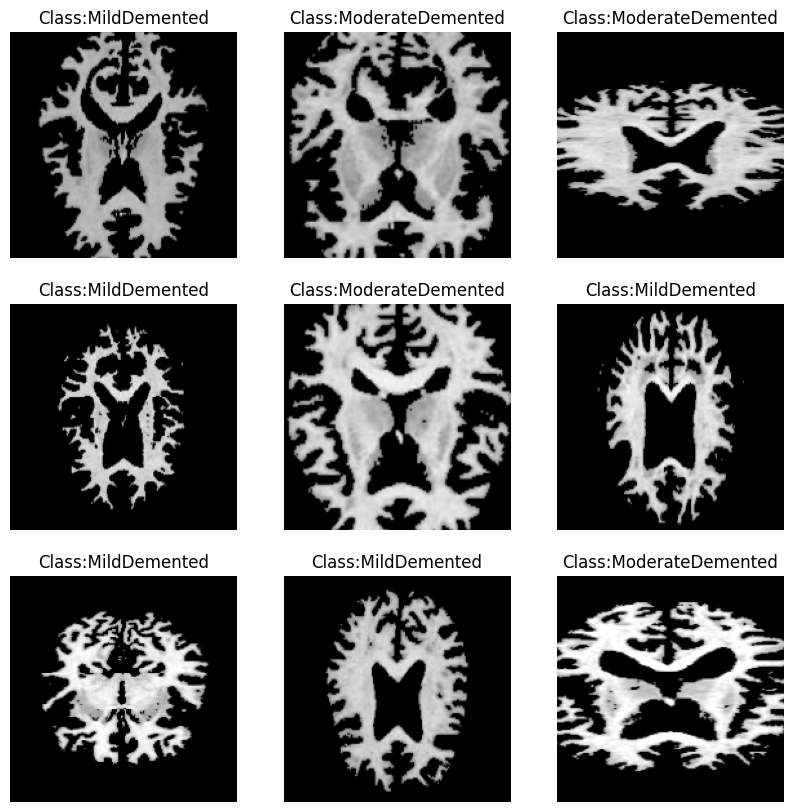

In [9]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [7]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [8]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [9]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [10]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [11]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [12]:
for layer in inception_model.layers:
    layer.trainable=False

In [13]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [14]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [15]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)       

In [18]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 50

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/50
256/256 [==============================] - 291s 1s/step - loss: 1.4194 - acc: 0.3954 - auc: 0.6618 - f1_score: 0.3929 - val_loss: 0.8376 - val_acc: 0.5923 - val_auc: 0.8671 - val_f1_score: 0.5582 - lr: 0.0010
Epoch 2/50
256/256 [==============================] - 283s 1s/step - loss: 0.9617 - acc: 0.5416 - auc: 0.8271 - f1_score: 0.5346 - val_loss: 0.6872 - val_acc: 0.6724 - val_auc: 0.9104 - val_f1_score: 0.6469 - lr: 0.0010
Epoch 3/50
256/256 [==============================] - 297s 1s/step - loss: 0.8190 - acc: 0.6174 - auc: 0.8764 - f1_score: 0.6096 - val_loss: 0.6245 - val_acc: 0.6992 - val_auc: 0.9268 - val_f1_score: 0.6767 - lr: 0.0010
Epoch 4/50
256/256 [==============================] - 333s 1s/step - loss: 0.7344 - acc: 0.6620 - auc: 0.9005 - f1_score: 0.6542 - val_loss: 0.5932 - val_acc: 0.7261 - val_auc: 0.9348 - val_f1_score: 0.7129 - lr: 0.0010
Epoch 5/50
256/256 [==============================] - 315s 1s/step - loss: 0.6983 - acc: 0.6890 - auc: 0.9114 - f1_score

Epoch 38/50
256/256 [==============================] - 307s 1s/step - loss: 0.2364 - acc: 0.9160 - auc: 0.9891 - f1_score: 0.9159 - val_loss: 0.2972 - val_acc: 0.8867 - val_auc: 0.9843 - val_f1_score: 0.8856 - lr: 1.0000e-04
Epoch 39/50
256/256 [==============================] - 299s 1s/step - loss: 0.2466 - acc: 0.9176 - auc: 0.9877 - f1_score: 0.9175 - val_loss: 0.2971 - val_acc: 0.8872 - val_auc: 0.9844 - val_f1_score: 0.8862 - lr: 1.0000e-04
Epoch 40/50
256/256 [==============================] - 304s 1s/step - loss: 0.2406 - acc: 0.9144 - auc: 0.9882 - f1_score: 0.9142 - val_loss: 0.2963 - val_acc: 0.8872 - val_auc: 0.9845 - val_f1_score: 0.8860 - lr: 1.0000e-05
Epoch 41/50
256/256 [==============================] - 308s 1s/step - loss: 0.2316 - acc: 0.9205 - auc: 0.9892 - f1_score: 0.9204 - val_loss: 0.2960 - val_acc: 0.8857 - val_auc: 0.9845 - val_f1_score: 0.8845 - lr: 1.0000e-05
Epoch 42/50
256/256 [==============================] - 301s 1s/step - loss: 0.2353 - acc: 0.9174 - a

In [20]:
custom_inception_model.save("inception_weight.h5")

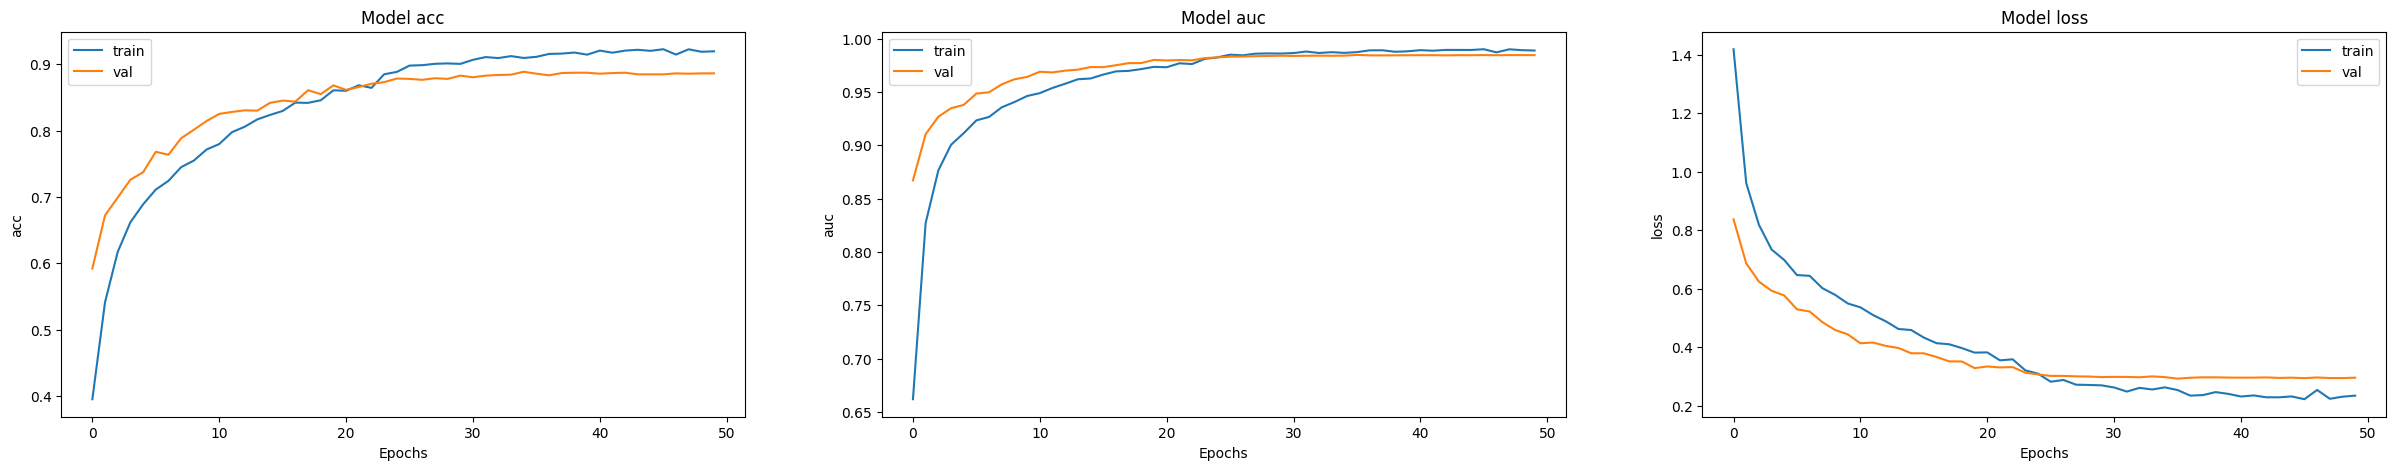

In [21]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [23]:
#Evaluating the model on the data

train_scores = custom_inception_model.evaluate(train_data, train_labels)
val_scores = custom_inception_model.evaluate(val_data, val_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 71s 890ms/step - loss: 0.3247 - acc: 0.8691 - auc: 0.9820 - f1_score: 0.8689
Training Accuracy: 98.84%
Validation Accuracy: 88.62%
Testing Accuracy: 86.91%


In [24]:
#Predicting the test data

pred_labels = custom_inception_model.predict(test_data)

80/80 [==============================] - 69s 847ms/step


In [25]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.92      0.95      0.93       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.84      0.73      0.78       662
ModerateDemented       0.73      0.81      0.77       624

       micro avg       0.87      0.87      0.87      2560
       macro avg       0.87      0.87      0.87      2560
    weighted avg       0.87      0.87      0.87      2560
     samples avg       0.87      0.87      0.87      2560



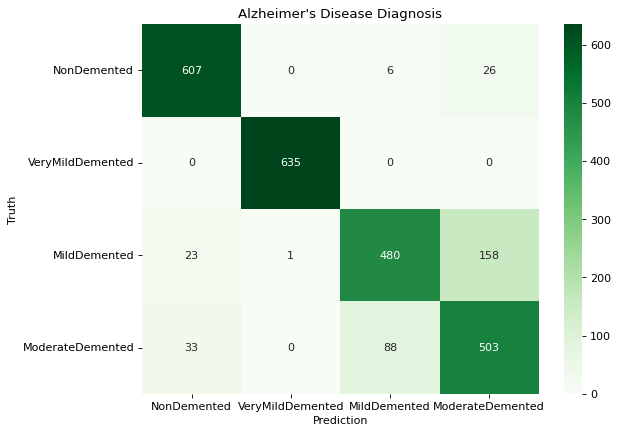

In [26]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [27]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 87.03 %
Matthew's Correlation Coefficient: 82.66 %
